In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
  !git clone https://github.com/mahynski/chemometrics.git
  !cd chemometrics; pip install -r requirements.txt
else:
  import sys
  sys.path.append('../../')

import chemometrics

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

fatal: destination path 'chemometrics' already exists and is not an empty directory.


In [2]:
import imblearn
import sklearn

from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd

Overview
-------------

This is an example of using PLS to create a model, following the procedures outlined in ["Detection of Outliers in Projection-Based Modeling," Rodionova and Pomerantsev, Analytical
    Chemistry 92 (2020) 2656−2664.](https://doi.org/10.1021/acs.analchem.9b04611)
    
Figure 1 from this paper illustrates the workflow:

![](https://raw.githubusercontent.com/mahynski/chemometrics/master/examples/pls_example_fig1.png)

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.144+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

pandas    : 1.3.5
watermark : 2.3.0
imblearn  : 0.0
sklearn   : 0.0
numpy     : 1.19.5
matplotlib: 3.2.2
IPython   : 5.5.0



# Load the Data

In [4]:
# Let's load some data from the tests/ for this example
if using_colab:
    loc = 'https://raw.githubusercontent.com/mahynski/chemometrics/master/tests/data/pls_train.csv'
else:
    loc = '../tests/data/pls_train.csv'
df = pd.read_csv(loc)

In [5]:
df.head()

,Group,Name,Water,9000,9016,9032,9048,9064,9080,9096,9112,9128,9144,9160,9176,9192,9208,9224,9240,9256,9272,9288,9304,9320,9336,9352,9368,9384,9400,9416,9432,9448,9464,9480,9496,9512,9528,9544,9560,9576,...,10248,10264,10280,10296,10312,10328,10344,10360,10376,10392,10408,10424,10440,10456,10472,10488,10504,10520,10536,10552,10568,10584,10600,10616,10632,10648,10664,10680,10696,10712,10728,10744,10760,10776,10792,10808,10824,10840,10856,10872
0,1,psh1079,13.1,1.200471,1.200235,1.197285,1.191587,1.182786,1.170456,1.154333,1.134429,1.111078,1.084625,1.055297,1.023256,0.988597,0.951446,0.911919,0.870078,0.825914,0.779344,0.730433,0.679085,0.624927,0.567821,0.508023,0.446277,0.383850,0.321851,0.260719,0.200441,0.140738,0.081256,0.021721,-0.038016,-0.098056,-0.158497,-0.219401,-0.280919,-0.343243,...,-0.686223,-0.555586,-0.423722,-0.292195,-0.162363,-0.035387,0.087811,0.206585,0.320786,0.430808,0.537046,0.639442,0.737048,0.827820,0.909309,0.979526,1.037262,1.082327,1.115495,1.137982,1.151093,1.155994,1.153482,1.144116,1.128449,1.107145,1.081046,1.051086,1.018251,0.983534,0.947764,0.911444,0.874897,0.838401,0.802317,0.767152,0.733518,0.702013,0.673171,0.647416
1,1,psh1080,13.1,1.118446,1.120228,1.119543,1.116151,1.109550,1.099261,1.085294,1.067804,1.046918,1.022780,0.995443,0.965146,0.932300,0.897147,0.859719,0.819980,0.777820,0.733117,0.685904,0.636108,0.583467,0.527927,0.469882,0.410196,0.350017,0.290266,0.231263,0.172852,0.114848,0.057134,-0.000549,-0.058419,-0.116635,-0.175374,-0.234697,-0.294689,-0.355502,...,-0.690518,-0.560234,-0.428575,-0.296960,-0.166597,-0.038645,0.085862,0.206226,0.322356,0.434750,0.543825,0.649396,0.750390,0.844767,0.930046,1.004057,1.065469,1.114081,1.150671,1.176479,1.192822,1.200794,1.201263,1.194911,1.182258,1.163941,1.140858,1.113940,1.084188,1.052563,1.019738,0.986162,0.952236,0.918314,0.884795,0.852187,0.821023,0.791809,0.765117,0.741465
2,1,psh1082,12.5,1.151631,1.153625,1.153154,1.149782,1.142985,1.132223,1.117273,1.098495,1.076249,1.050738,1.022195,0.990743,0.956488,0.919734,0.880725,0.839437,0.795636,0.749085,0.699733,0.647536,0.592397,0.534324,0.473669,0.411284,0.348239,0.285379,0.223054,0.161248,0.099990,0.039271,-0.021106,-0.081322,-0.141605,-0.202225,-0.263299,-0.324956,-0.387348,...,-0.621245,-0.488057,-0.354233,-0.221240,-0.090372,0.037151,0.160348,0.278656,0.391990,0.500777,0.605536,0.706177,0.801670,0.890173,0.969413,1.037319,1.092648,1.135201,1.165676,1.185331,1.195553,1.197501,1.192070,1.179816,1.161154,1.136694,1.107192,1.073682,1.037462,0.999512,0.960466,0.920775,0.880692,0.840490,0.800624,0.761642,0.724088,0.688496,0.655518,0.625669
3,1,psh1104,11.3,1.249430,1.246106,1.240054,1.231071,1.218746,1.202648,1.182540,1.158538,1.131046,1.100614,1.067570,1.031867,0.993572,0.952917,0.910070,0.865091,0.817907,0.768386,0.716527,0.662269,0.605233,0.545214,0.482641,0.418365,0.353494,0.288978,0.225233,0.162389,0.100421,0.039183,-0.021587,-0.082237,-0.143045,-0.204221,-0.265912,-0.328205,-0.391231,...,-0.568814,-0.427645,-0.286392,-0.146861,-0.010660,0.120711,0.245929,0.364144,0.475146,0.579312,0.677327,0.769475,0.855121,0.932802,1.000682,1.057171,1.101453,1.133619,1.154407,1.164969,1.166605,1.160363,1.146977,1.126976,1.100806,1.069021,1.032438,0.992050,0.948902,0.903909,0.857823,0.811211,0.764474,0.717992,0.672193,0.627514,0.584488,0.543758,0.505945,0.471541
4,1,psh1108,11.8,1.249200,1.249285,1.246747,1.241193,1.232022,1.218881,1.201564,1.180175,1.155099,1.126690,1.095252,1.061014,1.024078,0.984618,0.942839,0.898844,0.852644,0.804058,0.752771,0.698496,0.641080,0.580687,0.517935,0.453783,0.389260,0.325112,0.261617,0.198788,0.136634,0.075059,0.013812,-0.047333,-0.108565,-0.170052,-0.231952,-0.294474,-0.357832,...,-0.622985,-0.484378,-0.345335,-0.207593,-0.072607,0.058130,0.183248,0.302007,0.414347,0.520747,0.621811,0.717674,0.807549,0.889824,0.962446,1.023437,1.071590,1.106885,1.130239,1.143018,1.146645,1.142226,1.130504,1.111985,1.087126,1.056567,1.021130,0.981855,0.939898,0.896142,0.851214,0.80

In [6]:
raw_x = np.array(df.values[:,3:], dtype=float) # Extract features
raw_y = np.array(df['Water'].values, dtype=float) # Take the water content as the target

# Model the Data with PLS

In [7]:
from chemometrics.regressor.pls import PLS

## Training

In [8]:
model = PLS(n_components=1, alpha=0.05, gamma=0.01, scale_x=True)

In [9]:
_ = model.fit(raw_x, raw_y)

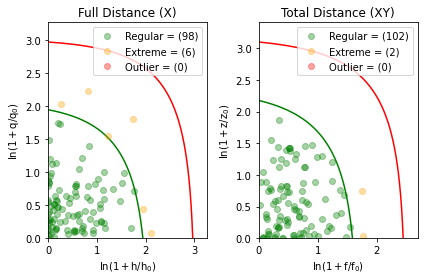

In [10]:
_ = model.visualize(raw_x, raw_y)

In [11]:
# We can predict the water content with model.predict(raw_x)
model.predict(raw_x)

array([[12.85925322],
       [12.99170771],
       [12.0644291 ],
       [11.35994524],
       [12.0004249 ],
       [12.96942061],
       [11.8951477 ],
       [11.89348395],
       [12.36920088],
       [12.37006495],
       [12.46654651],
       [11.70274461],
       [12.49127268],
       [13.2492494 ],
       [12.6971393 ],
       [11.73572268],
       [11.8234839 ],
       [12.03158665],
       [12.1121649 ],
       [11.9524923 ],
       [11.99322814],
       [12.39908269],
       [12.14624454],
       [12.18398517],
       [11.24459966],
       [11.54977815],
       [11.64547952],
       [13.12842557],
       [11.06497562],
       [11.54841086],
       [11.77807183],
       [11.91509363],
       [11.39989446],
       [11.28636669],
       [11.73845918],
       [11.53416868],
       [12.42932686],
       [12.66000371],
       [12.31264069],
       [12.13815894],
       [11.49554043],
       [11.8112226 ],
       [11.96543149],
       [11.5012801 ],
       [11.3594788 ],
       [11

In [12]:
# We can see what X data (if any) is extreme or is an outlier
extremes_mask, outliers_mask = model.check_x_outliers(raw_x)

In [13]:
# We could extract that data as follows:
extremes = raw_x[extremes_mask]
outliers = raw_x[outliers_mask]

In [14]:
# Number of X outliers, for example?
np.sum(outliers_mask)

0

In [15]:
# Number of X extremes, for example?
np.sum(extremes_mask)

6

In [16]:
# We can see what XY data (if any) is extreme or is an outlier
extremes_mask, outliers_mask = model.check_xy_outliers(raw_x, raw_y)

In [17]:
# Number of X outliers, for example?
np.sum(outliers_mask)

0

In [18]:
# Number of X extremes, for example?
np.sum(extremes_mask)

2

## Testing

In [19]:
if using_colab:
    loc = 'https://raw.githubusercontent.com/mahynski/chemometrics/master/tests/data/pls_test.csv'
else:
    loc = '../tests/data/pls_test.csv'
df = pd.read_csv(loc, header=None)

raw_x_t = np.array(df.values[:,3:], dtype=float)
raw_y_t = np.array(df.values[:,2], dtype=float)

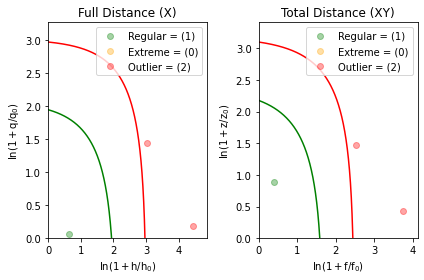

In [20]:
_ = model.visualize(raw_x_t, raw_y_t)

In [21]:
extremes_mask, outliers_mask = model.check_x_outliers(raw_x_t)

In [22]:
# Number of X extremes, for example?
np.sum(extremes_mask)

0

In [23]:
# Number of X outliers, for example?
np.sum(outliers_mask)

2

# Optimizing the Model

In [24]:
# Here I've use an imblearn pipeline, but you can also use scikit-learn's pipeline if you don't want to 
# do any class balancing.

pipeline = imblearn.pipeline.Pipeline(steps=[
    # Insert other preprocessing steps here...
    # ("smote", ScaledSMOTEENN(random_state=1)), # For example, class balancing
    ("pls", PLS(n_components=1, alpha=0.05, gamma=0.01, scale_x=True)
    )
])

# Hyperparameters of pipeline steps are given in standard notation: step__parameter_name
param_grid = [{
    # 'smote__k_enn':[1, 2, 3],
    # 'smote__k_smote':[1, 3, 3],
    # 'smote__kind_sel_enn':['all', 'mode'],
    'pls__n_components':np.arange(1, 10),
    # 'pls__alpha':[0.07, 0.05, 0.03, 0.01],
    # 'pls__scale_x': [True, False]
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.KFold(n_splits=3, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

_ = gs.fit(raw_x, raw_y)

In [25]:
# The best parameters found can be accessed like this:
gs.best_params_

{'pls__n_components': 8}

In [26]:
gs.best_score_ # The best (default is R^2, coefficient of determination) score it recieved was...

0.9047787466106775

In [27]:
# You can see detailed CV results here
gs.cv_results_

{'mean_fit_time': array([0.16576187, 0.20893462, 0.17797836, 0.23808519, 0.15378443,
        0.29775063, 0.19976807, 0.16813191, 0.1512808 ]),
 'mean_score_time': array([0.00409055, 0.00100819, 0.00156903, 0.00089256, 0.00088159,
        0.00091656, 0.0008053 , 0.00145157, 0.00085131]),
 'mean_test_score': array([0.37303945, 0.52708352, 0.84550775, 0.89838048, 0.89383861,
        0.89263778, 0.89178952, 0.90477875, 0.89211481]),
 'param_pls__n_components': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'pls__n_components': 1},
  {'pls__n_components': 2},
  {'pls__n_components': 3},
  {'pls__n_components': 4},
  {'pls__n_components': 5},
  {'pls__n_components': 6},
  {'pls__n_components': 7},
  {'pls__n_components': 8},
  {'pls__n_components': 9}],
 'rank_test_score': array([9, 8, 7, 2, 3, 4, 6, 1, 5], dtype=int32),
 'sp

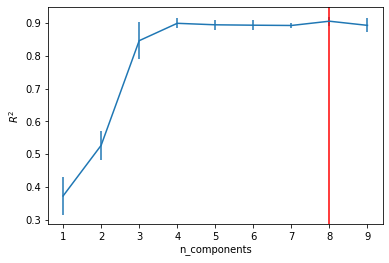

In [28]:
# For a 1D optimization you can easily visualize where the best value is
plt.errorbar(gs.cv_results_['param_pls__n_components'].data, 
             gs.cv_results_['mean_test_score'], 
             yerr=gs.cv_results_['std_test_score'])
plt.xlabel('n_components')
plt.ylabel(r'$R^2$')

plt.axvline(gs.best_params_['pls__n_components'], color='red')

In [29]:
# The refit=True (default) refits the model on the data in the end so you can use it directly on the test set.
gs.score(raw_x_t, raw_y_t)

0.46665749291184366

Text(0, 0.5, 'Predicted Water Content')

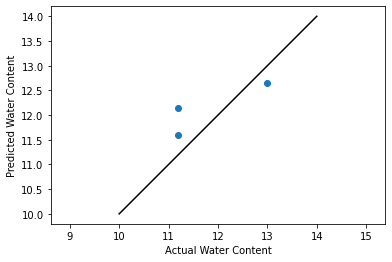

In [30]:
plt.plot(raw_y_t, gs.predict(raw_x_t), 'o')
plt.plot(np.linspace(10,14,100), np.linspace(10,14,100), 'k-')
plt.xlim(10,14)
plt.ylim(10,14)
_ = plt.axis('equal')
plt.xlabel('Actual Water Content')
plt.ylabel('Predicted Water Content')

# Outlier Detection

Steps 1 and 2 in the workflow at the beginning of this document are handled by the last step with CV. Now we can turn to optimizing the training set by removing outliers.

In [31]:
optimal_model = PLS(n_components=8, alpha=0.05, gamma=0.01, scale_x=True)
_ = optimal_model.fit(raw_x, raw_y)

## Step 3

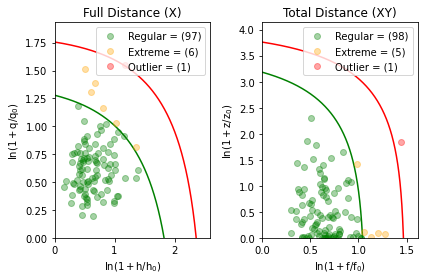

In [32]:
_ = optimal_model.visualize(raw_x, raw_y)

In [33]:
extremes, outliers = optimal_model.check_xy_outliers(raw_x, raw_y)

In [34]:
np.sum(outliers) # Indeed, we have 1 outlier

1

## Step 4

In [35]:
# Select data that is NOT an outlier (regular and extreme points)
new_x = raw_x[~outliers]
new_y = raw_y[~outliers]

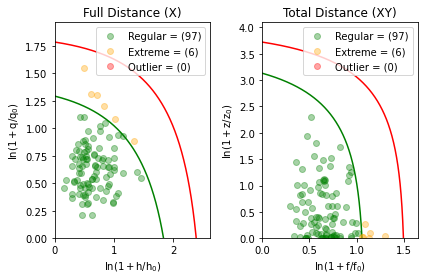

In [36]:
# After retraining the model we see there are no outliers - a "clean" training set
_ = optimal_model.fit(new_x, new_y)
_ = optimal_model.visualize(new_x, new_y)

## Step 5

In [38]:
# _ = optimal_model.visualize(raw_x[outliers], raw_y[outliers])

Outliers remain outliers, so the model is "stable" and Step 6 is not required.  This code always uses robust statistical methods for estimating internal parameters, so Step 7 is not performed.